# MNIST Image Classification example using LeNet (Tensorflow backend)
In this example, we are going to demonstrate how to train a MNIST image classification model using LeNet model architeture with Tesnorflow backend. 

## Import the required libraries

In [1]:
import tensorflow as tf
import fastestimator as fe
import numpy as np
import matplotlib.pyplot as plt
import tempfile

In [2]:
#training parameters
epochs = 2
batch_size = 32
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation datasets and prepare FastEstimator's pipeline.

### Load dataset 
We use fastestimator API to load the MNIST dataset and get the test set by splitting 50% evaluation set. 

In [3]:
from fastestimator.dataset.data import mnist

train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)

### Set up preprocessing pipline
In this example, the data preprocessing steps include expanding image dimension and normalizing the pixel value to range [0, 1]. We set up those processing step using `Ops` and meanwhile define the data source (loaded dataset) and batch size. 

In [4]:
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=batch_size,
                       ops=[ExpandDims(inputs="x", outputs="x_out"), 
                            Minmax(inputs="x_out", outputs="x_out")])

### Validate `Pipeline`
In order to make sure the pipeline works as expected, we need to visualize the output of pipeline image and check its size.
`Pipeline.get_results` will return a batch data of pipeline output. 
 

In [5]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]

print("the pipeline input data size: {}".format(data_xin.numpy().shape))
print("the pipeline output data size: {}".format(data_xout.numpy().shape))
print("the maximum pixel value of output image: {}".format(np.max(data_xout.numpy())))
print("the minimum pixel value of output image: {}".format(np.min(data_xout.numpy())))

the pipeline input data size: (32, 28, 28)
the pipeline output data size: (32, 28, 28, 1)
the maximum pixel value of output image: 1.0
the minimum pixel value of output image: 0.0


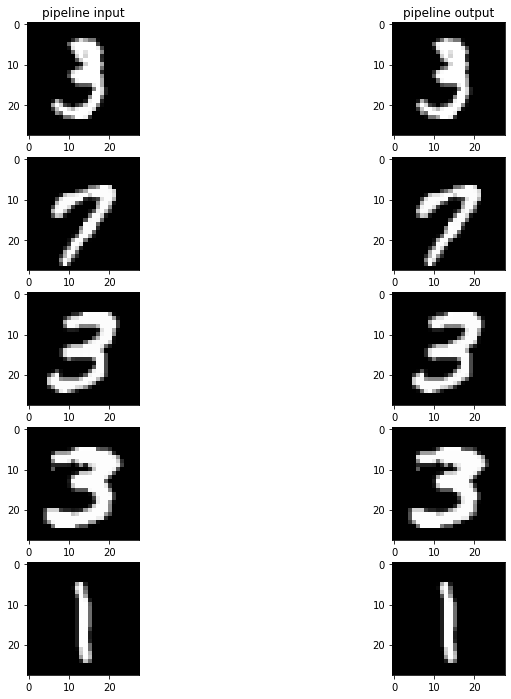

In [6]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 2, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")


for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in, cmap="gray")
    
    img_out = data_xout.numpy()[j,:,:,0]
    axs[i,1].imshow(img_out, cmap="gray")

## Step 2 - `Network` construction
**FastEstimator supports both Pytorch and Tensorflow, so this section can use both backend to implement.** <br>
We are going to only demonstate the Tensorflow way in this example.

### Model construction
Here the model definition is going to be imported from the FastEstimator pre-defined architecture that is implemented in Tensorflow, and we create model instance by compiling it with specific model optimizer.

In [7]:
from fastestimator.architecture.tensorflow import LeNet

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

### `Network` definition
We are going to connect the model and `Ops` together into a `Network`. `Ops` are the basic component of `Network`. They can be logic for loss calculation, model update units, and even model itself is also considered as an `Op`. 

In [8]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


network = fe.Network(ops=[
        ModelOp(model=model, inputs="x_out", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce", mode="!infer")
    ])

## Step 3 - `Estimator` definition and training
In this step, we define the `Estimator` to connect the `Network` with `Pipeline` and set the `traces` which compute accuracy (Accuracy), save best model (BestModelSaver), and change learning rate (LRScheduler) 

In [9]:
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy


traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="accuracy", save_best_mode="max"),
    LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=3750, init_lr=1e-3))
]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.2952478; model_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.3141091; steps/sec: 331.75; model_lr: 0.000998283; 
FastEstimator-Train: step: 200; ce: 0.2921242; steps/sec: 327.33; model_lr: 0.0009930746; 
FastEstimator-Train: step: 300; ce: 0.030078162; steps/sec: 339.11; model_lr: 0.0009844112; 
FastEstimator-Train: step: 400; ce: 0.37753928; steps/sec: 339.46; model_lr: 0.00097235345; 
FastEstimator-Train: step: 500; ce: 0.014425077; steps/sec: 328.28; model_lr: 0.000

## Model testing
`Estimator.test` triggers model testing with test dataset that specified in `Pipeline`. We can evaluate the model performance in the classification accuracy. 

In [10]:
estimator.test()

FastEstimator-Test: epoch: 2; accuracy: 0.9892; 


## Images inference 
In this step we run image inference directly using the model that just trained. 
We randomly select 5 images from testing dataset and infer them image by image with `Pipeline.transform` and `Netowork.transform`

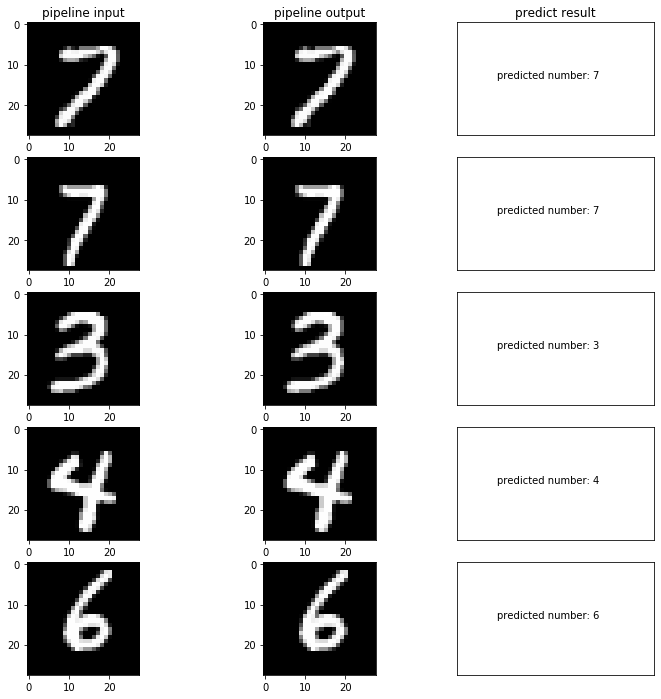

In [11]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 3, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")
axs[0,2].set_title("predict result")

for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    data = {"x": test_data["x"][j]}
    axs[i,0].imshow(data["x"], cmap="gray")
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    img = data["x_out"].squeeze(axis=(0,3))
    axs[i,1].imshow(img, cmap="gray")
    
    # run the network
    data = network.transform(data, mode="infer")
    predict = data["y_pred"].numpy().squeeze(axis=(0))
    axs[i,2].text(0.2, 0.5, "predicted number: {}".format(np.argmax(predict)))
    axs[i,2].get_xaxis().set_visible(False)
    axs[i,2].get_yaxis().set_visible(False)